In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from IPython.display import Image


from statsmodels.sandbox.stats.multicomp import multipletests

В данной задаче вам нужно пронаблюдать эффект, который основные методы коррекции при множественной проверки гипотез оказывают на количественные характеристики критериев — FDR, FWER, мощность. В качестве примера рассматривается проверка односторонних гипотез для компонент вектора средних $\theta$ трёхмерного нормального распределения с известной матрицей ковариаций $\Sigma$. 

**Описание эксперимента**

Дана выборка $X = (X_1, \ldots, X_n)$ из трёхмерного нормального распределения с неизвестным вектором средних ${\theta}$ и известной матрицей ковариаций ${\Sigma}$ и вектор ${\theta_0}$. Для каждой из компонент вектора при помощи равномерно наиболее мощного критерия проверяется пара гипотез: $\mathsf{H}_j\colon\ \theta_j = \theta_j^0\ \ vs.\ \ \mathsf{H}'_j\colon\ \theta_j > \theta_j^0$, где $j\in\{1,2,3\}, \theta = (\theta_1, \theta_2, \theta_3), \theta_0 = (\theta_1^0, \theta_2^0, \theta_3^0)$. Уровень значимости для каждой из гипотез примем равным $\alpha = 0.05$.

Для простоты, в рамках эксперимента из каждой альтернативы будем рассматривать только одно значение $ \theta_j^1 \gg \theta_j^0 $, где ${\theta^{1}}$ — известный вектор. Для вектора средних ${\theta}$ рассматриваются все возможные комбинации: $ \theta_j = \theta_j^0\ \ vs.\ \ \theta_j = \theta_j^1$. В предположениях каждой из них генерируется выборка из $\mathcal{N}({\theta}, {\Sigma})$ и проверяются гипотезы. Эксперимент повторяется достаточное число раз, после чего вычисляются FDR, FWER и мощность критериев (доля правильно отвергнутых гипотез). Формально, вычисляются оценки данных величин.
Вначале эксперименты проводятся без МПГ-коррекции на каждом шаге, затем — с ней. Результаты сравниваются.

Всё вышеописанное повторяется для следующих матриц ковариаций:
1. Диагональная 
    $
    {\Sigma} = \begin{pmatrix} 
                           \alpha & 0 & 0\\ 
                           0 & \beta & 0\\ 
                           0 & 0 & \gamma 
                       \end{pmatrix}
    $;
2. Вырожденная $
    {\Sigma} = \begin{pmatrix} 
                           \alpha & \alpha & \alpha\\ 
                           \alpha & \alpha & \alpha\\ 
                           \alpha & \alpha & \alpha 
                       \end{pmatrix}
    $;
3. Произвольная ${\Sigma}$, не подходящая под условия 1 и 2.

**Реализация**

Вам предоставлен интерфейс для работы с классом `ExperimentHandler` из файла `mht.py`, который должен лежать в той же папке, что и ваш ipynb-файл. Вся работа с `ExperimentHandler` уже встроена в шаблон, *не меняйте ни класс, ни шаблон*. 

От вас требуется реализовать РНМК, вычисление FWER, FDR и мощности, а также три метода МПГ-коррекции — метод Бонферрони, метод Холма и метод Бенджамини-Иекутиели в файле `utils.py`. Классы-заглушки выдаются, вам нужно только заполнить содержательные пропуски в их реализации. Необходимость в реализации методов МПГ-коррекции вызвана тем, что данные методы в statsmodels реализованы не оптимально, и их использование в данной задаче загрузит ваш компьютер на несколько часов. 

Для пущей вычислительной эффективности, каждый метод коррекции принимает на вход *матрицу* p-value размерностей `(число_экспериментов, число_гипотез)` и выдаёт тоже *матрицы*: 
* булевую матрицу `reject`, которая указывает, какие именно гипотезы отвергаются;
* числовую матрицу `adjusted`, содержащую скорректированные p-value.

В данном случае число гипотез равно размерности многомерного нормального распределения, т.е. трём. Коррекция строк производится *независимо*, т.е. метод коррекции нужно применить к каждой строке, а результаты собрать в матрицу. Для вашего удобства, в шаблоне расставлены `assert`-ы, которые проверяют базовую адекватность ваших результатов. В силу нетривиальности векторизации этих методов (кроме Бонферрони), **разрешено использовать цикл по экспериментам**. Цикл по гипотезам тоже можно сделать, поскольку в данной задаче их всего три.

Код РНМК, на вход которому тоже подаётся матрица, должен быть полностью векторизован.

*Если вы ошибётесь в формулах, все ваши последующие усилия будут напрасны, потому будьте внимательны.*

#### 1. Теоретические формулировки

**a**. Напишите определения FWER, FDR, а также мощности процедуры МПГ

Пусть $V_{p, s}$ - кол-во отвергнутых верных гипотез, $R_s$ - кол-во отвергнутых гипотез, $m$ - кол-во гипотез и $m_0$ - кол-во верных гипозе, тогда 

$$FWER = P(V_{p, s} > 0)$$
$$FDR = E_p \frac{V_{p, s}}{max(R_s, 1)}$$

**b.** Методы МПГ-коррекции. 

Напишите явно, какие величины (FDR, FWER) эти методы контролируют, а также приведите формулы пересчёта p-value и опишите процедуру, по которой определяется, какие из гипотез отвергнуть, а какие нет.  

* *Метод Бонферрони*

Краткое описание:

$\alpha_j = \frac{\alpha}{m}$, $\widetilde{p_j} = min(1, mp_j)$

* *Метод Холма*

Краткое описание:

Отсортируем $p_k$, тогда $\alpha_j = \frac{\alpha}{m - j + 1}$ , $\widetilde{p_j} = min(1, max(\widetilde{p_{j - 1}}, p_j(m - j + 1)))$

* *Метод Бенджамини-Иекутиели*

Краткое описание:

Отсортируем $p_k$, тогда 
$\alpha_j = \dfrac{j\alpha}{m \sum_{i = 1}^m\frac{1}{i}}$, $\widetilde{p_j} = min(1, min(\widetilde{p_{j + 1}}, p_j\frac{m\sum_{i = 1}^m\frac{1}{i}}{j}))$

**с.** Реализация РНМК 

Выпишите формулу РНМК для проверки гипотез $\mathsf{H}_0\colon\ \theta = \theta_0\ \ vs.\ \ \mathsf{H}_1\colon\ \theta > \theta_0$ для $\mathcal{N}(\theta, \sigma^2)$ с известной дисперсией (одномерный случай).

$H_0:\theta = \theta_0$ vs $H1:\theta > \theta_0$
$T(x) = \sqrt{n} \dfrac{\overline{x} - \theta_0}{\sigma}$, $S = \{T(x) \geq c_{\alpha}\}$, где $c_{\alpha} = q_{1 - \alpha}$ - $1 - \alpha$ квантиль $N(0, 1)$ 

#### 2. Реализация.
В файле `utils.py` вам нужно реализовать подсчет FWER, FDR и мощности, а также три метода МПГ-коррекции: метод Бонферрони, метод Холма и метод Бенджамини-Иекутиели.

**Файл `utils.py` необходимо прислать вместе с ноутбуком.**

In [7]:
from mht import ExperimentHandler, AdjustmentMethodABC, AdjustmentMethodTester

In [8]:
%load_ext autoreload
%autoreload 2

from utils import compute_fwer, compute_fdr, compute_power, criterion, \
                  BonferroniAdjustment, HolmAdjustment, BenjaminiYekutieliAdjustment

*Замечание*. Обратите внимание на первые строчки в ячейке выше. Расширение [`autoreload`](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) позволяет перезагружать модуль перед выполнением кода в ячейке, что позволяет вам вносить правки в `utils.py` без необходимости ручной перезагрузки модулей.

#### 3. Подготовка к экспериментам.

Установим значения величин ${\theta_0}, {\theta_1}, {\Sigma}$, а также уровня значимости, числа запусков эксперимента и размера выборки в каждом из них.  
Эти параметры остаются неизменными от итерации к итерации. Для отладки выставляйте `n_runs = 100` или меньше.

In [9]:
theta_list = np.array([
    [0, 0, 0],
    [1, 1, 1]
])
sample_size = 4  # размер выборки на каждой итерации
n_runs = int(1e6)  # число экспериментов для каждой из 8 конфигураций
alpha = 0.05  # уровень значимости
random_seed = 42  # random_state (для воспроизводимости)

# методы коррекции p-значений (не менять)
correction_methods = [
    BonferroniAdjustment(alpha=alpha),
    HolmAdjustment(alpha=alpha),
    BenjaminiYekutieliAdjustment(alpha=alpha)
]
method_names = ["bonferroni", "holm", "fdr_by"]
experiment_results = {}

Убедимся в корректности нашей реализации, сравнив с эталонным решением из библиотеки `statsmodels`, а также проверим базовыми тестами подсчет FWER, FDR, мощности.  

In [10]:
tester = AdjustmentMethodTester(correction_methods, method_names, 
                                compute_fwer, compute_fdr, compute_power)

tester.run_tests()

перебор методов: 0it [00:00, ?it/s]

Метод Бонферрони. Проверка корректности.


итерации проверки:   0%|          | 0/100 [00:00<?, ?it/s]

Метод Холма. Проверка корректности.


итерации проверки:   0%|          | 0/100 [00:00<?, ?it/s]

Метод Бенджамини-Иекутиели. Проверка корректности.


итерации проверки:   0%|          | 0/100 [00:00<?, ?it/s]

Все тесты пройдены!


#### 4. Эксперименты

**a.** Диагональная матрица ${\Sigma}$

перебираем тройки верных гипотез: 0it [00:00, ?it/s]

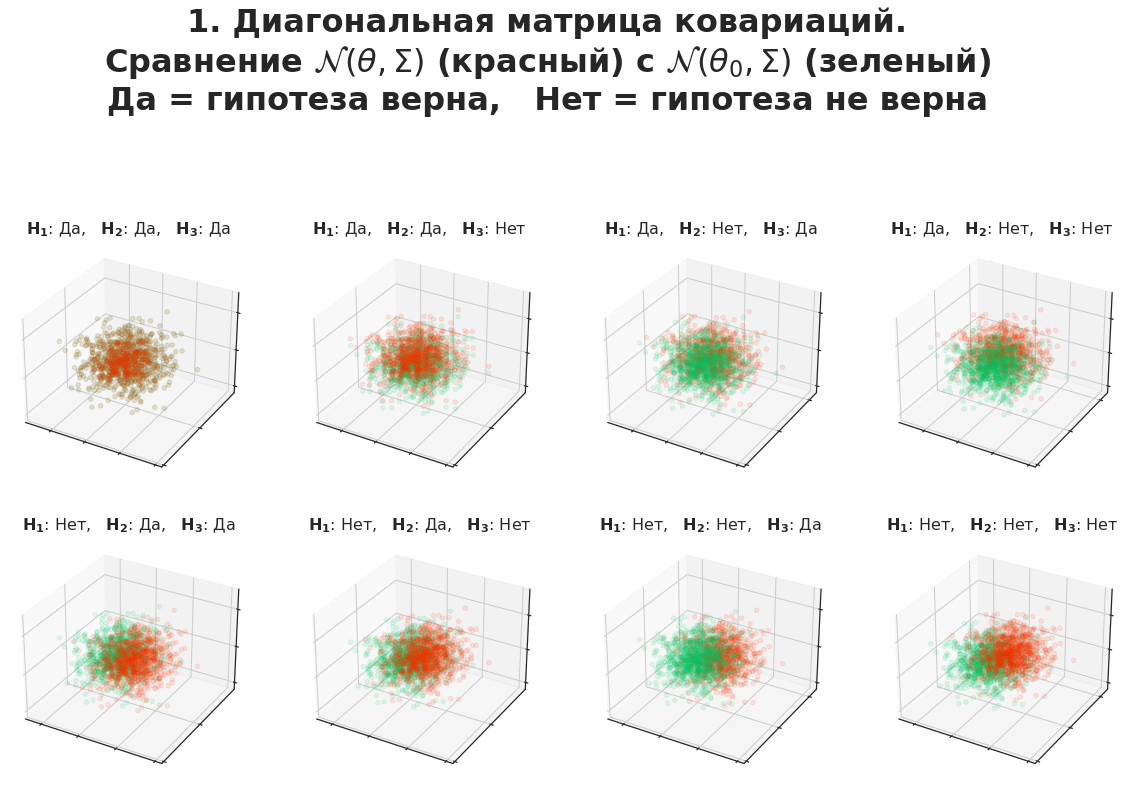

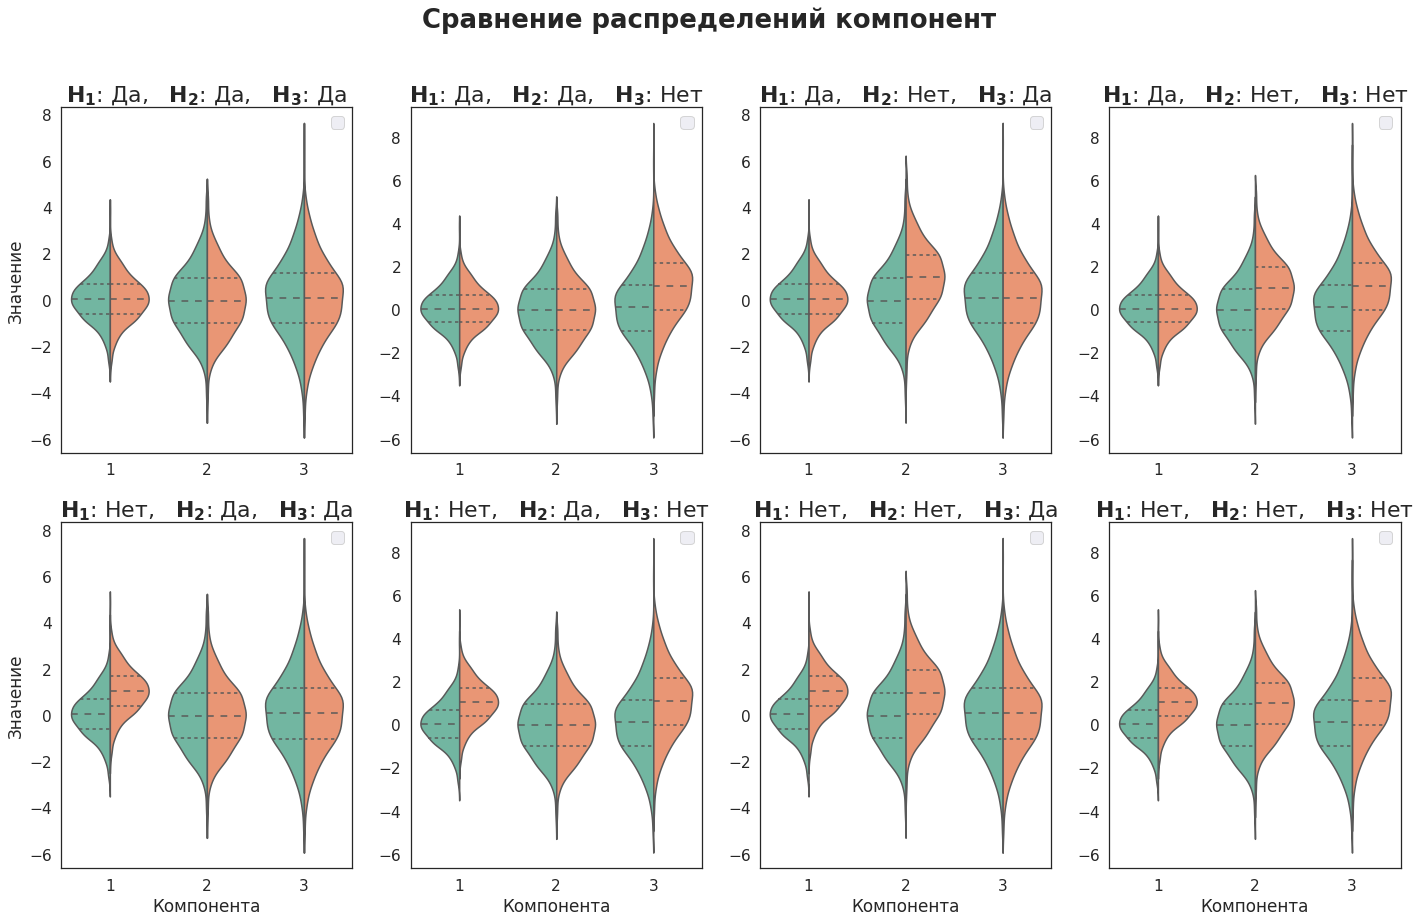

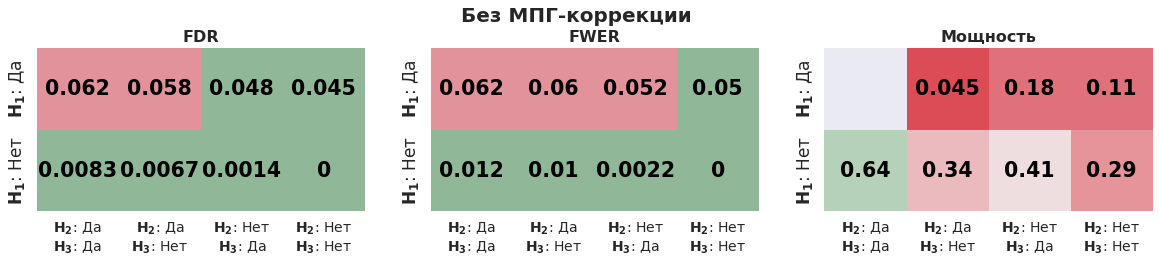

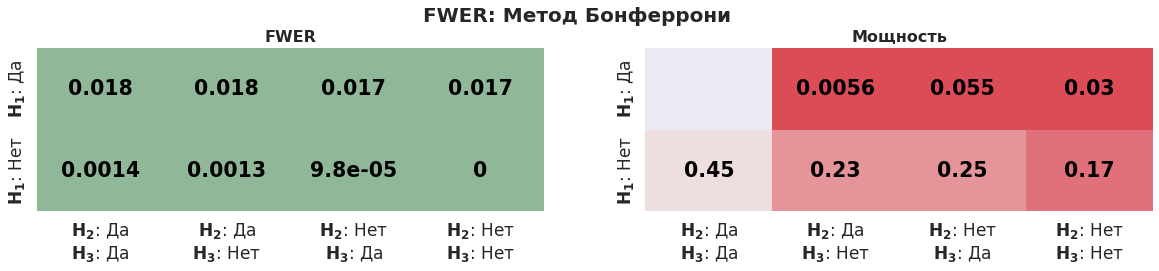

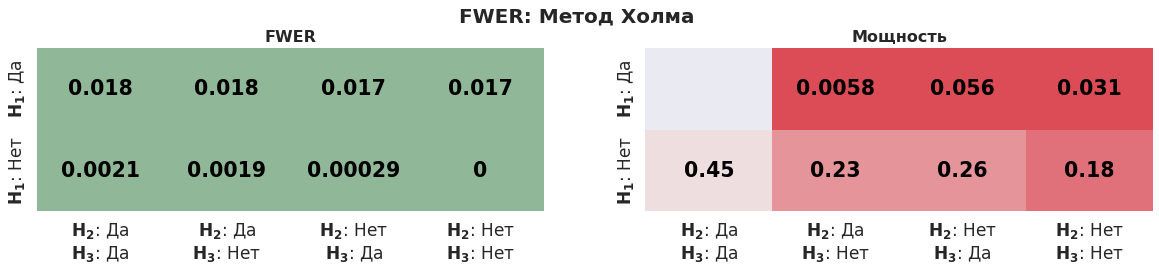

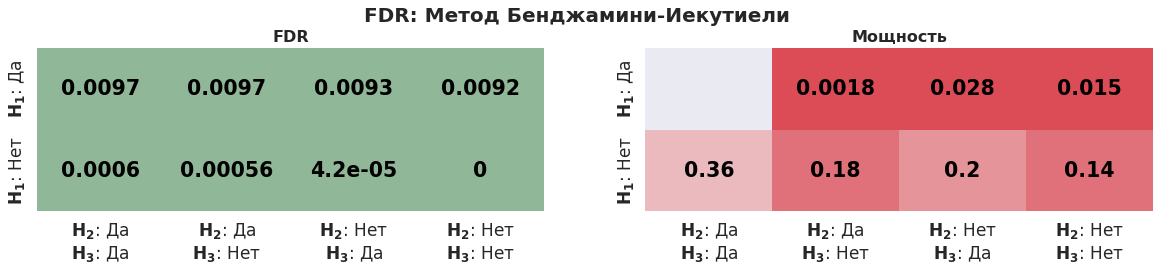

In [11]:
Sigma = np.diag([1, 2, 3])

experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="1. Диагональная матрица ковариаций",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["1"] = experiment.run()

**b.** Вырожденная матрица ${\Sigma}$

перебираем тройки верных гипотез: 0it [00:00, ?it/s]

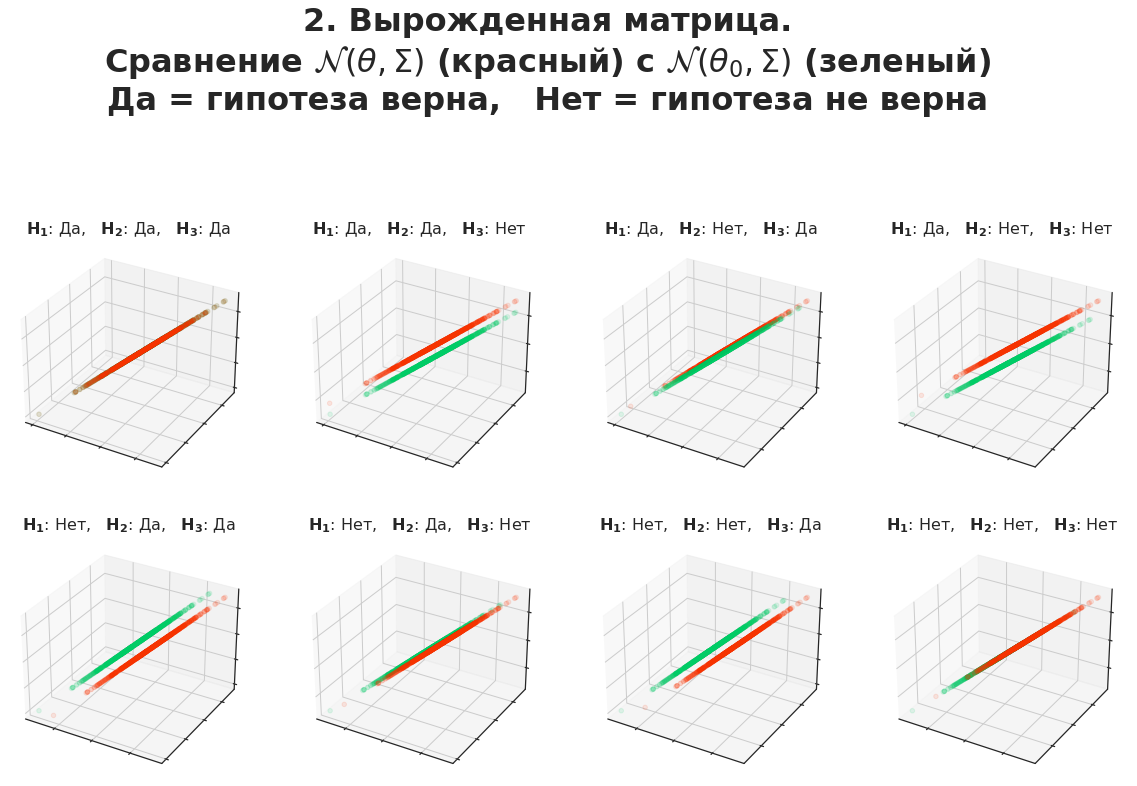

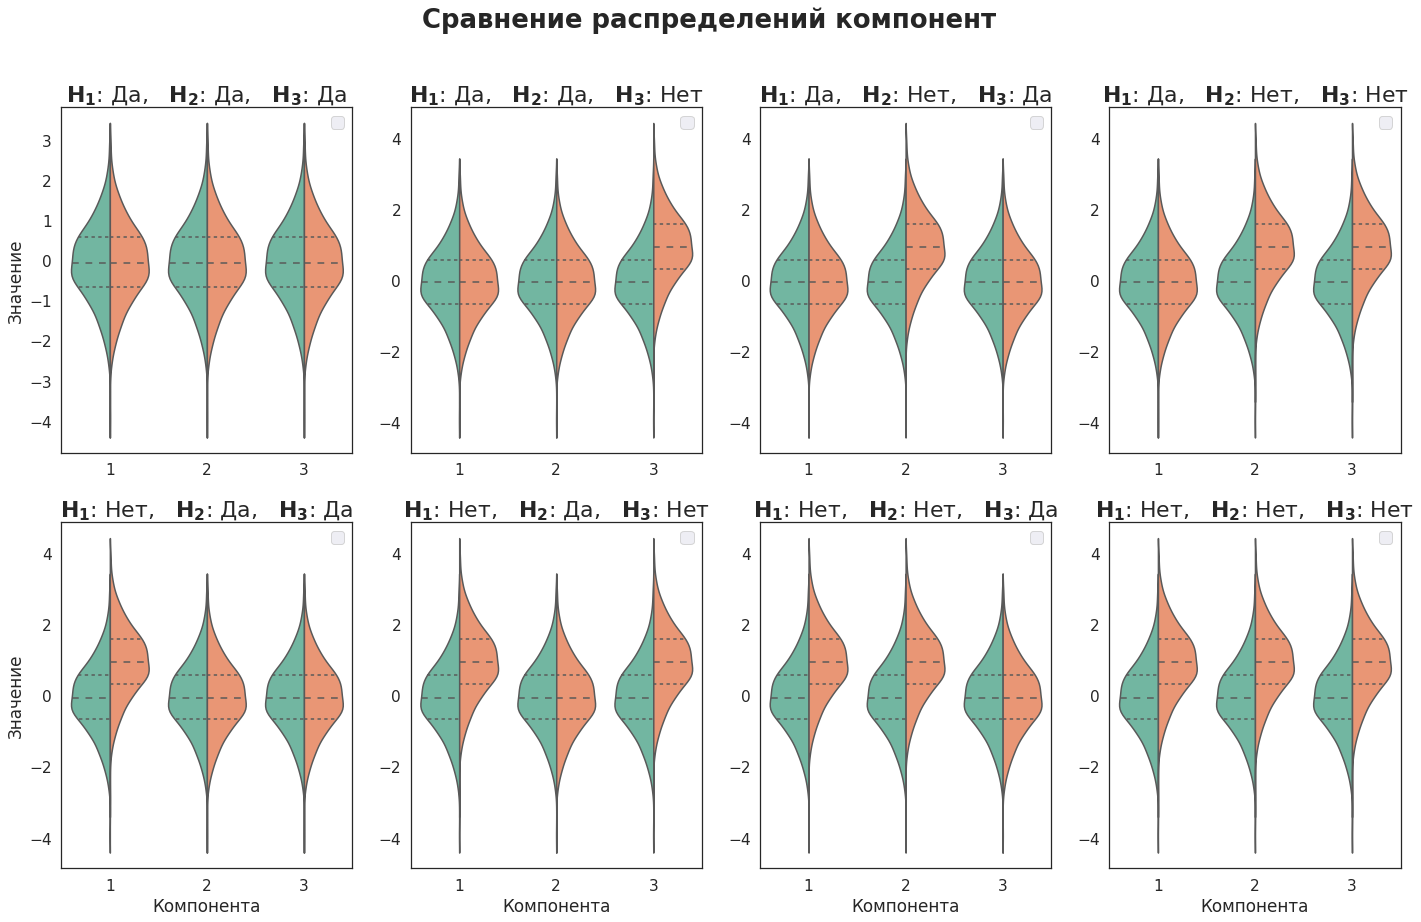

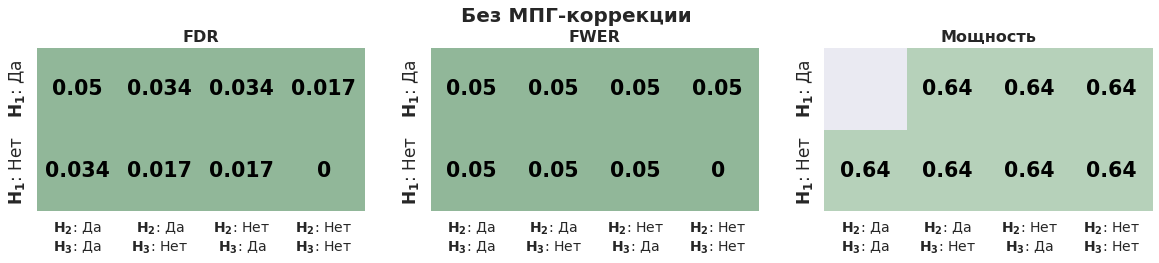

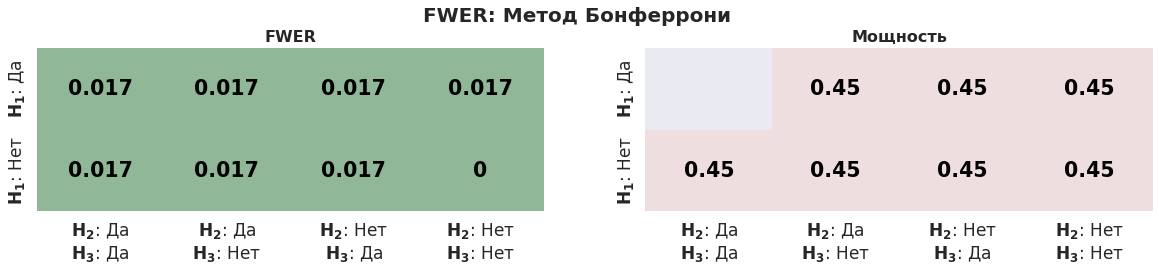

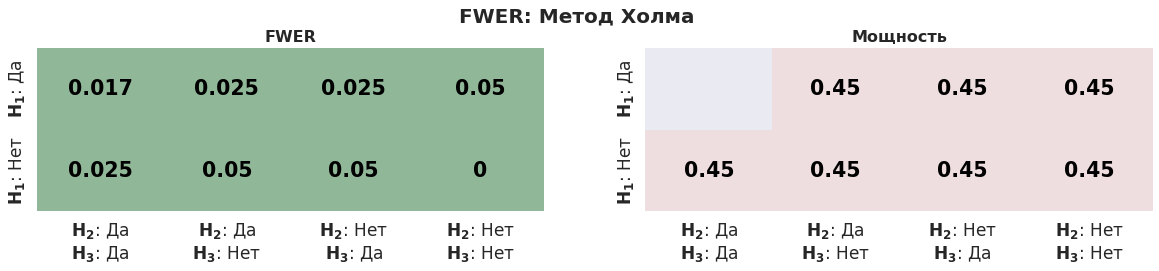

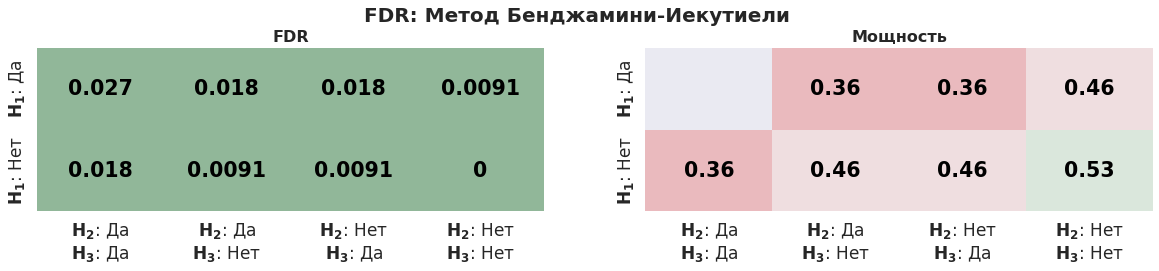

In [12]:
Sigma = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="2. Вырожденная матрица",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["2"] = experiment.run()

**с.** Произвольная матрица ковариаций ${\Sigma}$

перебираем тройки верных гипотез: 0it [00:00, ?it/s]

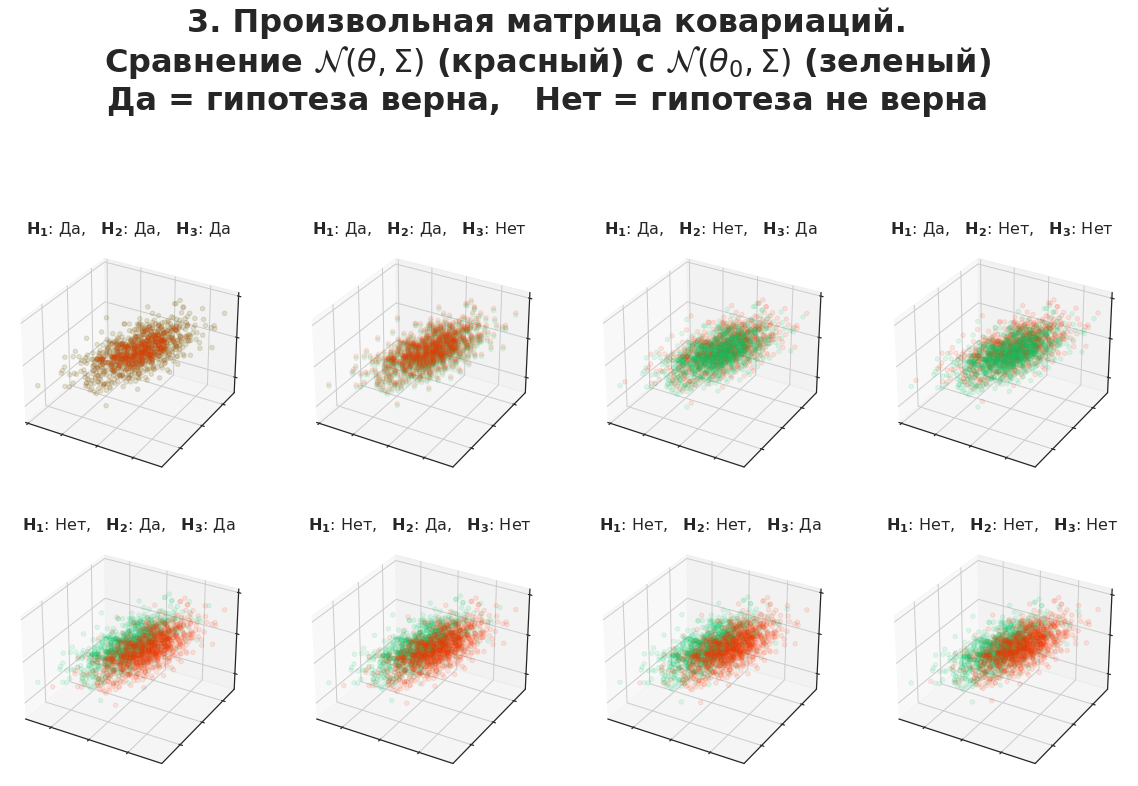

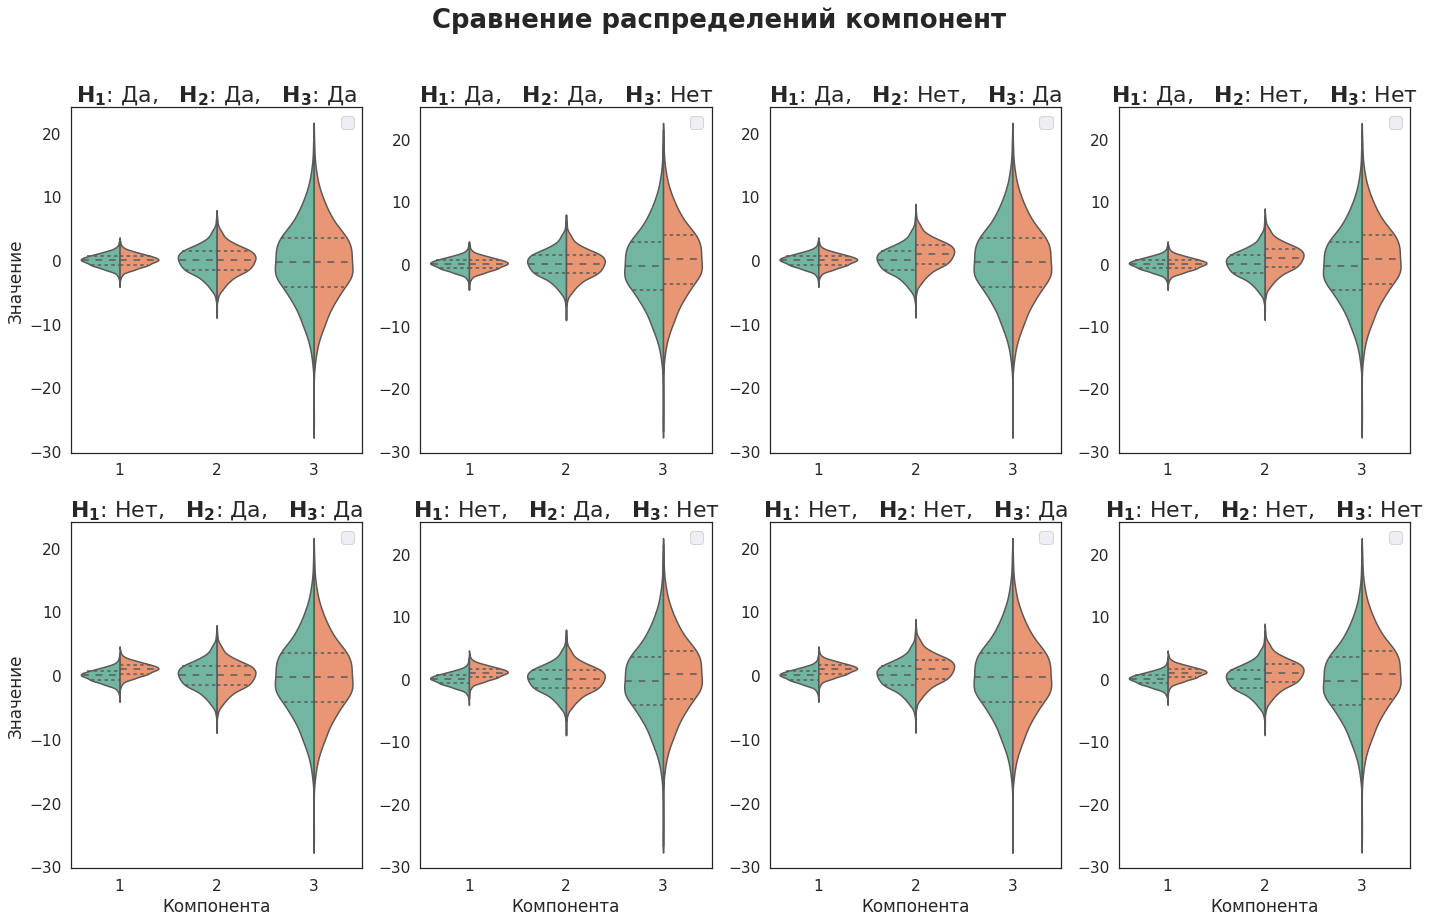

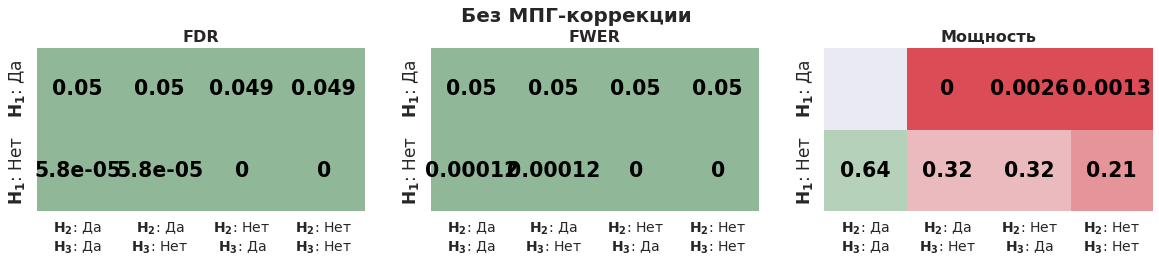

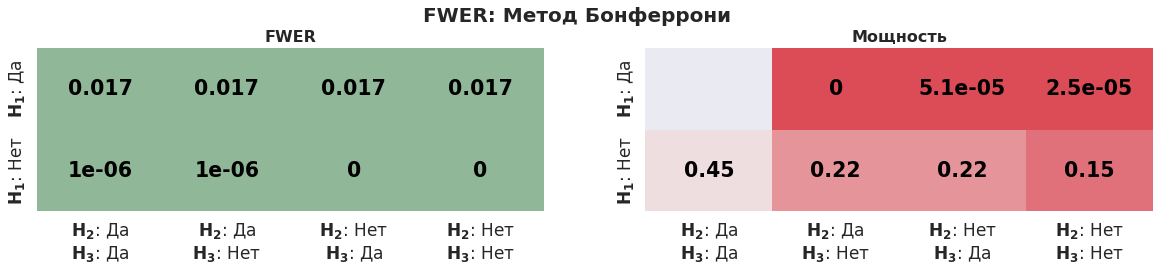

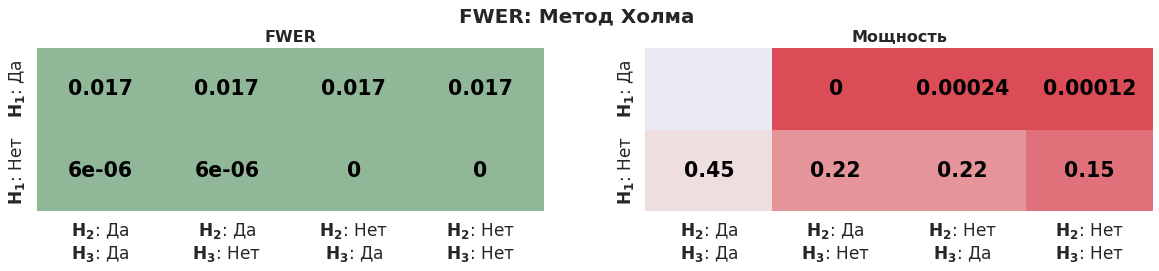

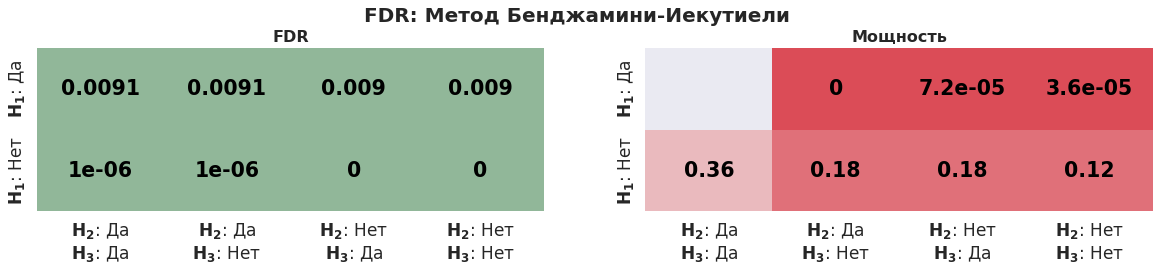

In [14]:
Sigma = np.array([[1, 2, 3], 
                  [2, 5, 9], 
                  [3, 9, 37]])

assert (np.all(Sigma == Sigma.T) 
        and np.all(np.linalg.eigvals(Sigma) >= 0)),\
    "Это не матрица ковариаций."

experiment = ExperimentHandler(
    theta_list=theta_list, 
    Sigma=Sigma,
    cov_mx_description="3. Произвольная матрица ковариаций",
    alpha=alpha,
    n_runs=n_runs,
    sample_size=sample_size, 
    random_seed=random_seed,
    correction_methods=correction_methods,
    criterion=criterion,
    compute_fwer=compute_fwer,
    compute_fdr=compute_fdr,
    compute_power=compute_power
)
experiment_results["3"] = experiment.run()

#### 5. Вывод.

Опишите, какие свойства методов МПГ-коррекции вы пронаблюдали. Обоснуйте, почему методы МПГ-коррекции обязательно нужно применять. Поясните, что будет, если этого не делать.

Если говорить про FDR и FWER, то почти у всех случаев FDR больше у Бенджамини-Иекутиели, чем у Холма. Наверное это как-то связано с тем, что Бенджамини-Иекутиели — восходящая процедура, а Холм напротив нисходящая. 